In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 15 Lab - Time Series

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

This lab covers time series data.  The exact flow may look a little different from the ETL/EDA/Modeling sequence that we've become familiar with from linear models, but we will follow the same general process.  Complete each of the following according to the course notes in Module 15.

## 1: Load the data, cleaning and transforming as necessary.


First let's load our data.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/timeseries.csv')
# add the rest of your code below here

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    180 non-null    object 
 1   value   180 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


The `date` column looks like it's not actually a `datetime64` dtype, so we'll want to convert that so pandas handles it the way we want it to.  This will help with many plotting functions as well.  In general, dates and times can often be somewhat difficult to work with because they can be encoded as strings (`"2020-01-01"`), integers (`20200101`), or objects, and this can pose challenges when trying to convert between different encodings.  For example, some tools/libraries may automatically treat a string encoded date as a type of category - which may be an illogical encoding for certain types of computations.  Dates and times can also be deconstructed into component years, months, days, hours, minutes, etc., and when working with time data you will often go back and forth between single timepoints, inteverals, and durations.  For this reason many languages/libraries/tools will provide datetime objects that offer a standard way of handling the complexity of conversions and operations.  Fortunately we don't need to concern ourselves with any of that here, but it's worth pointing out.  Another type of "complex data type" along the same lines would be geographies, which typically have similar hierarchies of country/region/city/etc.

In [3]:
# convert the `date` field to datetime objects.
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,value
0,2019-01-01,64.51
1,2019-01-02,1.67
2,2019-01-03,84.41
3,2019-01-04,119.14
4,2019-01-05,20.78


Great.  That's about all we should need to do here for ETL.

## 2: Perform EDA on the time variable and describe what kind of time series (trend, seasonality, etc).

For EDA, all we really need to do is plot out our time series, as we did in the course notes.  We can then examine and characterize any features in the time series.

In [4]:
def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

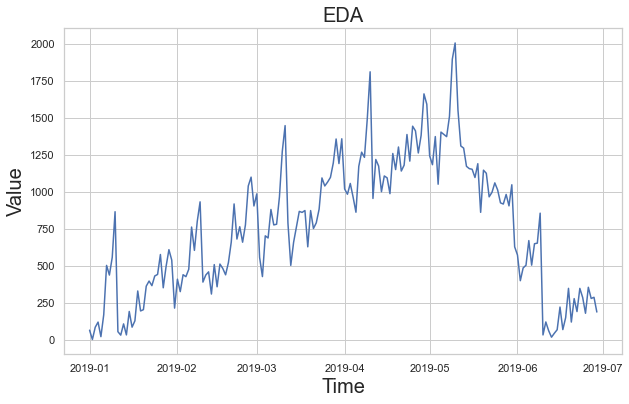

In [70]:
plot_time_series(df['date'], df['value'], "EDA")

There is a considerable amount of noise in this series, but we definitely observe a clear upward trend throughout its course from 2019-01 to 2019-05.  Interestingly there is a steep dip after that point, however the trend does appear to recover towards the very end.

We can also observe some distinct seasonality in the series, with a period of about 30 days.

## 3: Create models with each of Simple Exponential Smoothing, Holts Trend Correction and Holts Winters Seasonality Adjustment. Choose an error (SSE, etc) and compare the three models. How are they different, and why?

We could start to model the data with the level.  However, given the very noticible trending in the series, we shouldn't expect a level model to be very good.

In [6]:
average = df[ "value"].mean()
print(average)

759.9637222222223


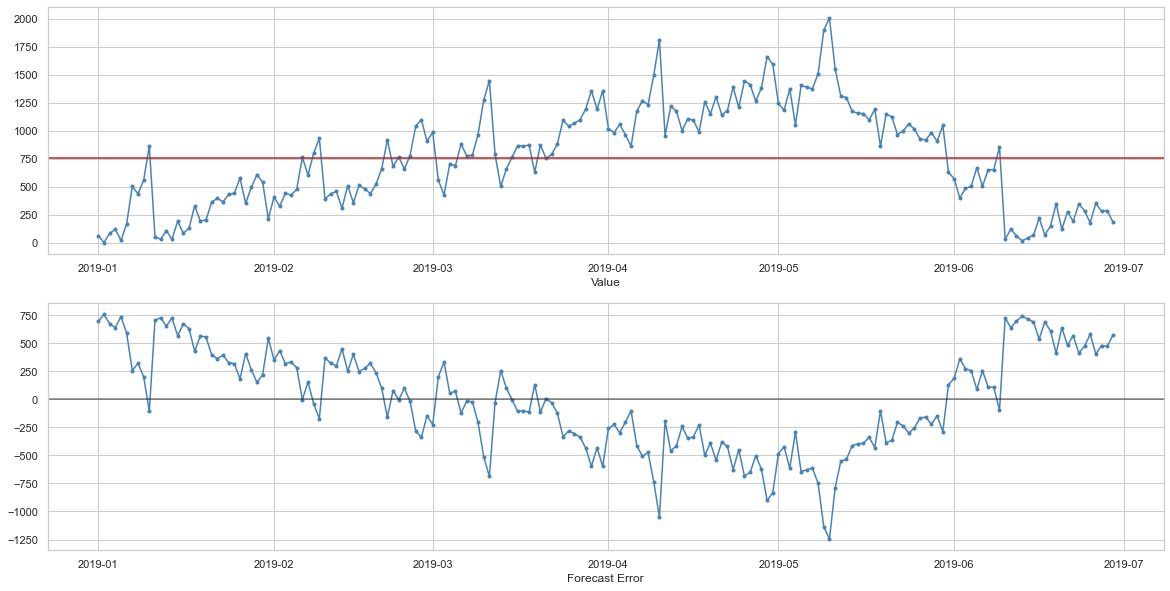

In [7]:
figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["date"], df[ "value"], color="steelblue", marker=".")
axes.axhline(y=average, xmin=0, xmax=40, c="firebrick")
axes.set_xlabel( "Value")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["date"], average - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

Sure enough, the level model fails to take into account the trend of the data.

Let's try Simple Exponential Smoothing, following along from the course notes.


In [8]:
def ses_forecast( level_0, alpha, actual):
    n = len( actual)
    ses = [level_0]
    for i in range( 1, n):
        level = ses[ i - 1] + alpha * (actual[ i - 1] - ses[ i - 1])
        ses.append( level)
    return pd.Series( ses)

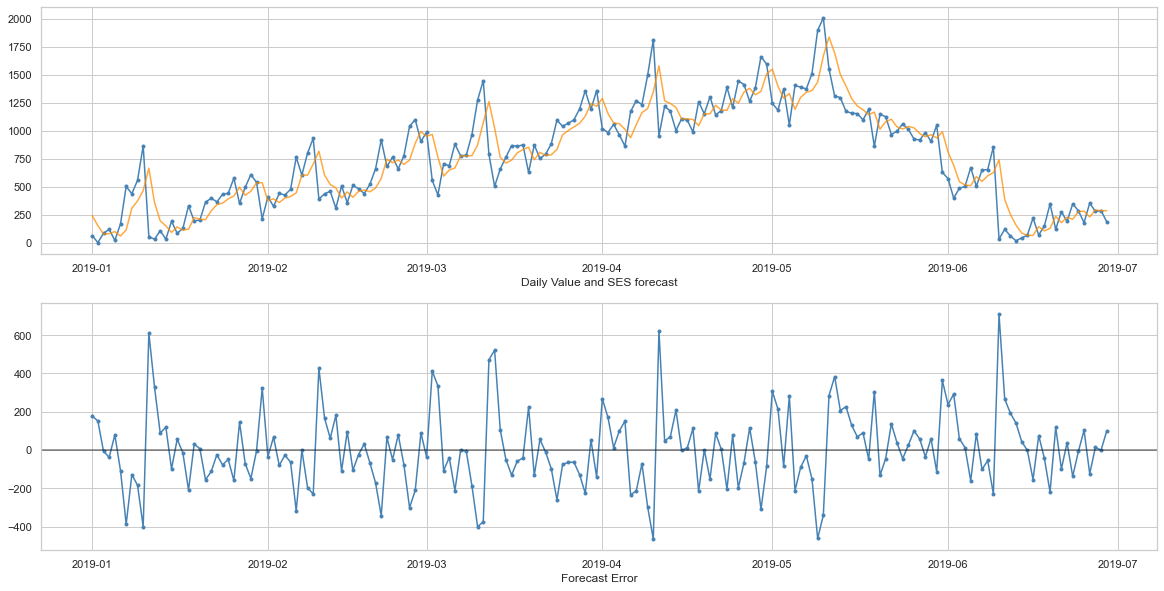

In [9]:
early_average = df["value"][ 0:12].mean()
alpha = 0.5
df[ "ses"] = ses_forecast( early_average, alpha, df[ "value"] )
df[ "ses0"] = ses_forecast( early_average, 0.0, df[ "value"] )
df[ "ses1"] = ses_forecast( early_average, 1.0, df[ "value"])

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["date"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["date"], df[ "ses"], color="darkorange", alpha=0.75)
axes.set_xlabel( "Daily Value and SES forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["date"], df[ "ses"] - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

The SES model actually tracks fairly close with the real data.

Let's next try Holt's Trend Corrected Smoothing.  We can again bring in all the functions we used in the course notes.

In [10]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

def describe_fit( result):
    formula = result[ "formula"]
    print("regression: ", formula)
    print("n: ", result[ "n"])
    print("----------")
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print(variable.strip() + ": ", coefficient)
    print("----------")
    print("sigma", result[ "sigma"])
    print("R^2", result[ "r^2"])    

def holts_one_step( alpha, gamma, level, trend, error):
    this_trend = trend + gamma * alpha * error
    this_level = level + trend + alpha * error
    return (this_trend, this_level)

def holts_forecast( level_0, trend_0, alpha, gamma, actual):
    n = len( actual)
    trend, level = trend_0, level_0
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        forecast = level + trend
        forecasts.append( forecast)
        
        error = actual[ i] - forecast

        trend, level = holts_one_step( alpha, gamma, level, trend, error)
        
        trends.append( trend)
        levels.append( level)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends))    

Now something we need to consider here is that `date` is not currently a numerical term.  One way to do that is to convert the date to "day of year" (if all dates are within the same year).  We could have also just converted the date object to an int.  As mentioned earlier, working with date/time data often involves these kinds of operations.

In [25]:
# df['date_num'] = df['date'].astype(int)
df['day_num'] = df['date'].dt.dayofyear

We can fit a linear model to the first several days of the time series to find the parameters for our Holts forecast.

In [27]:
describe_fit( lm( "value ~ day_num", data = df[ 0:17]))

regression:  value ~ day_num
n:  17
----------
intercept:  186.1741911764707
day_num:  1.8616911764705826
----------
sigma 249.24429335188478
R^2 0.0015152182332092146


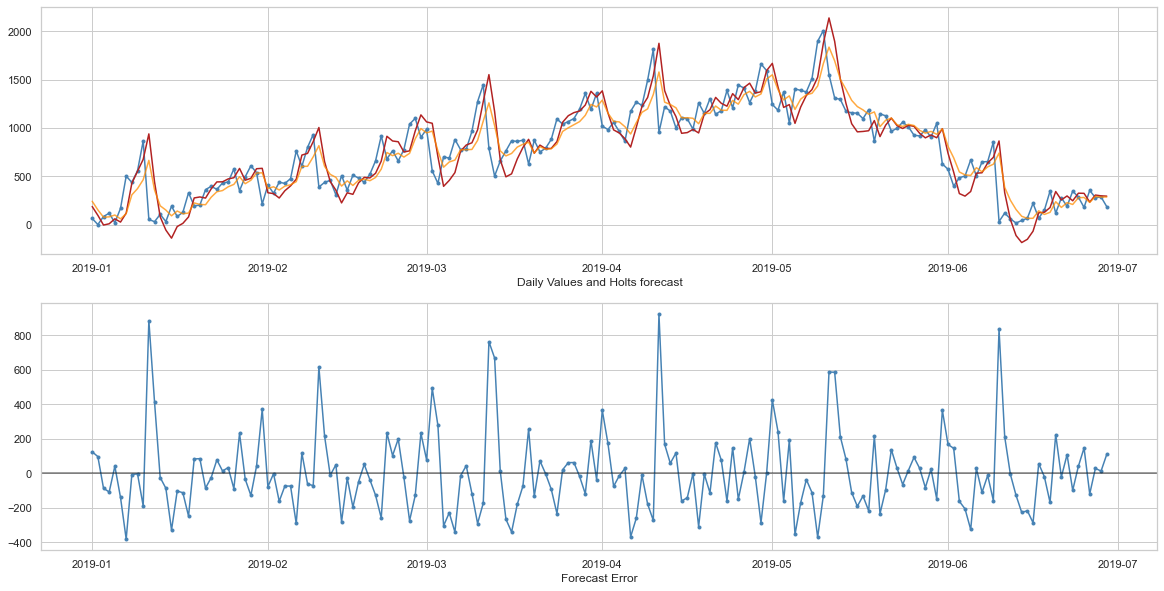

In [31]:
holts, levels, trends = holts_forecast( 186.17, 1.861, 0.5, 0.5, df[ "value"])
df[ "holts"] = holts
df[ "holts_level"] = levels
df[ "holts_trend"] = trends

figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["date"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["date"], df[ "holts"], color="firebrick")
axes.plot( df["date"], df[ "ses"], color="darkorange", alpha=0.75)
axes.set_xlabel( "Daily Values and Holts forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["date"], df[ "holts"] - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

The application of Holts Winters Seasonality Adjustment similarly follows from the course notes.

## 4: Choose one of the models and find its optimal parameters (ie, α).

Let's find α and γ for our Holts Trend Corrected Smoothing model.  We can use a grid search to search for the optimal values and plug them into the forecast model.


In [78]:
grid_search = []
for alpha in [_/100 for _ in list(range(100))]:
    for gamma in [_/100 for _ in list(range(100))]:
        holts, _, _ = holts_forecast( 186.17, 1.861, alpha, gamma, df[ "value"])
        sse = ((holts - df[ "value"])**2.0).sum()
        grid_search.append({ 'alpha': alpha, 'gamma': gamma, 'sse': int(sse)})

gs = pd.DataFrame(grid_search)
gs[gs.sse == gs.sse.min()]        

,alpha,gamma,sse
6400,0.64,0.0,6954954


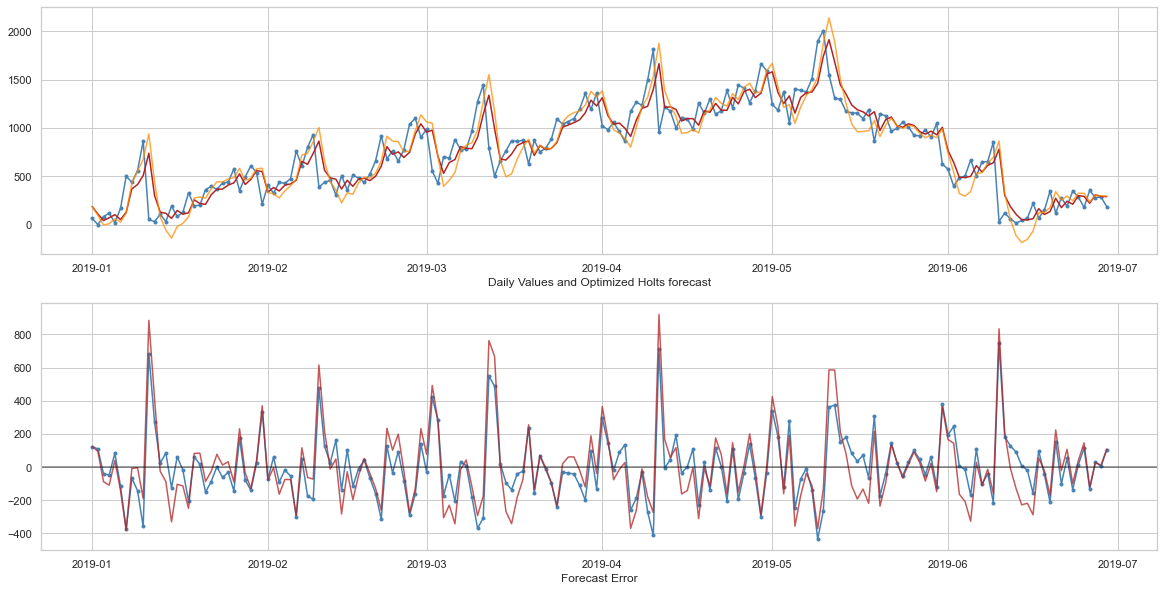

In [64]:
holts, levels, trends = holts_forecast( 186.17, 1.861, 0.64, 0.0, df[ "value"])
df[ "opt_holts"] = holts
df[ "opt_holts_level"] = levels
df[ "opt_holts_trend"] = trends

figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["date"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["date"], df[ "opt_holts"], color="firebrick")
axes.plot( df["date"], df[ "holts"], color="darkorange", alpha=0.75)
axes.set_xlabel( "Daily Values and Optimized Holts forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["date"], df[ "opt_holts"] - df[ "value"], color="steelblue", marker=".")
axes.plot( df["date"], df[ "holts"] - df[ "value"], color="firebrick", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

The optimized parameters indeed show a lower error at most peaks. 

##  5: Finally, pick one of the models from above and forecast some future values.

Again following along with the course notes, we can forecast a few future values.

In [75]:
# t = 38 (index 37)
print(df[ "holts_level"][179] + 1.0 * df[ "holts_trend"][179])

216.8169024926089


In [76]:
print(df[ "holts_level"][179] + 2.0 * df[ "holts_trend"][179])

192.46232120688848


In [77]:
print(df[ "holts_level"][179] + 3.0 * df[ "holts_trend"][179])

168.10773992116802
